# 3. Model Training and Evaluation with Multiple Models

In [1]:
## 1. Import Libraries
# Standard libraries
import os
import shutil
import time
import warnings
import multiprocessing
import concurrent.futures

# Data manipulation and analysis
import numpy as np
import pandas as pd

from sklearn.experimental import enable_halving_search_cv
# Machine learning
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    cross_val_score,
    KFold,
    HalvingGridSearchCV
)
from sklearn.experimental import enable_halving_search_cv  # Required for HalvingGridSearchCV
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    precision_recall_curve,
    average_precision_score,
    auc,
    roc_curve,
    recall_score,
    balanced_accuracy_score,
    precision_score,
    f1_score,
    log_loss
)

# Specialized ML libraries
import xgboost as xgb
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Model persistence
import joblib

In [2]:
# Check if we need to change working directory
current_dir = os.getcwd()
target_dir = os.path.dirname(current_dir)  # Get parent directory

if current_dir.endswith('notebooks'):  # Only change if we're in notebooks directory
    os.chdir('..')
    print(f"Changed working directory from {current_dir} to {os.getcwd()}")
else:
    print(f"Working directory already set to {current_dir}")

os.makedirs('data', exist_ok=True)  
os.makedirs('models', exist_ok=True) 

Changed working directory from c:\Work\GIT\Fraud-Detection-in-Job-Postings-A-Comprehensive-ML-Pipeline-Tutorial\notebooks to c:\Work\GIT\Fraud-Detection-in-Job-Postings-A-Comprehensive-ML-Pipeline-Tutorial


### Data Preparation and Oversampling with SMOTE

#### Purpose:
- Prepares features and target for training
- Balances the training data using SMOTE (Synthetic Minority Over-sampling Technique)
- Saves the data splits for future use

#### Operations:
1. **Separate Features and Target**:
   - Drops the target column (`fraudulent`) and any columns containing 'cleaned' from the feature set.
   - Separates the target variable `fraudulent`.

2. **Split Data with Stratification**:
   - Splits the data into training and test sets with stratification to maintain the class distribution.

3. **Display Original Class Distribution**:
   - Prints the class distribution of the training set before applying SMOTE.

4. **Determine Sampling Strategy**:
   - Calculates the sampling strategy based on the oversampling ratio.
   - The minority class is over-sampled by generating synthetic examples along the line segments joining the k nearest neighbors of each minority class sample.

5. **Apply SMOTE with Stratification**:
   - Uses SMOTE to balance the training data with the specified oversampling ratio.
   - SMOTE generates synthetic samples by taking the difference between a feature vector and its nearest neighbor, multiplying this difference by a random number between 0 and 1, and adding it to the feature vector. This selects a random point along the line segment between two specific features.
   - The implementation uses five nearest neighbors by default (`k_neighbors=5`).

6. **Create Class Distribution Tables**:
   - Creates tables showing the class distributions and their ratios for the original, balanced, and test sets.

7. **Save Data Splits**:
    - Saves the balanced training set, original training set, and test set to pickle files.

#### Why It's Important:
- **Balances the training data**: Ensures that the model is not biased towards the majority class by generating synthetic samples for the minority class.
- **Maintains class distribution in test set**: Stratified splitting ensures that the test set maintains the same class distribution as the original dataset.
- **Prepares data for modeling**: Saves the processed data splits for future use in model training and evaluation.


In [3]:
## 2. Load and Prepare Data
def prepare_and_save_data(df, oversampling_ratio=5.0,test_size=0.2):
    """Prepare features and target for training, and save the splits"""
    print("Preparing data splits...")
    
    # Separate features and target
    X = df.drop(['fraudulent'] + [col for col in df.columns if 'cleaned' in col], axis=1)
    y = df['fraudulent']
    
    # Split data with stratification
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42, stratify=y
    )
    
    # Display original class distribution
    original_class_distribution = pd.Series(y_train).value_counts()
    
    # Determine the sampling strategy based on the oversampling ratio
    minority_class_count = original_class_distribution.min()
    sampling_strategy = {original_class_distribution.idxmin(): int(minority_class_count * oversampling_ratio)}
    
    # Apply SMOTE with stratification
    print(f"\nApplying SMOTE to balance training data with a ratio of {oversampling_ratio}...")
    smote = SMOTE(random_state=42, sampling_strategy=sampling_strategy,k_neighbors=5)  # Adaptive k_neighbors)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
    
       
    # Convert to pandas
    X_train_balanced = pd.DataFrame(X_train_balanced, columns=X_train.columns)
    y_train_balanced = pd.Series(y_train_balanced)
    
    # Display balanced class distribution
    balanced_class_distribution = pd.Series(y_train_balanced).value_counts()
    
    # Display test target distribution
    test_class_distribution = pd.Series(y_test).value_counts()
    
    # Create a table with class distributions
    class_distribution_table = pd.DataFrame({
        'Total': original_class_distribution + test_class_distribution,
        'Target': original_class_distribution,
        'Target_Balanced': balanced_class_distribution,
        'Test': test_class_distribution
    })
    
    # Create a table with class distribution ratios
    class_distribution_ratios = class_distribution_table.div(class_distribution_table.sum(axis=0), axis=1)
    
    print("\nClass distribution table:")
    print(class_distribution_table)
    
    print("\nClass distribution ratios:")
    print(class_distribution_ratios)
    
    # Save the splits
    print("\nSaving data splits...")
    pd.to_pickle(X_train_balanced, 'data/X_train_balanced.pkl')
    pd.to_pickle(X_train, 'data/X_train.pkl')
    pd.to_pickle(X_test, 'data/X_test.pkl')
    pd.to_pickle(y_train_balanced, 'data/y_train_balanced.pkl')
    pd.to_pickle(y_train, 'data/y_train.pkl')
    pd.to_pickle(y_test, 'data/y_test.pkl')
    
    print("Data splits saved successfully!")
    
    return X_train_balanced, X_test, y_train_balanced, y_test

# Example usage
df = pd.read_pickle('data/engineered_features.pkl')

X_train_balanced, X_test, y_train_balanced, y_test = prepare_and_save_data(df, oversampling_ratio=5.0,test_size=0.2)

Preparing data splits...

Applying SMOTE to balance training data with a ratio of 5.0...

Class distribution table:
   Total  Target  Target_Balanced  Test
0  17014   13611            13611  3403
1    866     693             3465   173

Class distribution ratios:
      Total    Target  Target_Balanced      Test
0  0.951566  0.951552         0.797084  0.951622
1  0.048434  0.048448         0.202916  0.048378

Saving data splits...
Data splits saved successfully!


In [4]:
#https://medium.com/dvt-engineering/hyper-parameter-tuning-for-scikit-learn-ml-models-860747bc3d72

### 2.Model Parameter Grids



#### Function: `get_xgboost_params`

This function returns an automated parameter grid for XGBoost based on the characteristics of the training data. The parameters included in the grid are critical for controlling the complexity and performance of the XGBoost model.

#### Explanation:

1. **max_depth**:
   - **Values**: [3, 4, 5] for ≤ 10 features, [4, 5, 6] for ≤ 50 features, [5, 6, 7] for > 50 features
   - **Why?**: The max_depth parameter controls the maximum depth of each tree. A deeper tree can capture more complex patterns but may also lead to overfitting. By testing a range of depths, we can find a balance between model complexity and generalization.

2. **learning_rate**:
   - **Values**: [0.01, 0.1] for ≤ 1000 samples, [0.01, 0.1, 0.2] for ≤ 10000 samples, [0.01, 0.1, 0.2, 0.3] for > 10000 samples
   - **Why?**: The learning_rate  parameter controls the step size at each iteration while moving toward a minimum of the loss function. A lower learning rate makes the model more robust to overfitting but requires more trees. Including a range of learning rates helps in finding the optimal trade-off between learning speed and model accuracy.

3. **n_estimators**:
   - **Values**: [100, 200] for ≤ 1000 samples, [100, 200, 500] for ≤ 10000 samples, [100, 200, 500, 1000] for > 10000 samples
   - **Why?**: The n_estimators  parameter specifies the number of trees to be used in the model. More trees can improve performance but also increase computation time. Testing different values helps in determining the optimal number of trees for the dataset.

### Summary

This function provides a comprehensive parameter grid for XGBoost, allowing for extensive hyperparameter tuning to optimize model performance. The parameters are determined based on the characteristics of the training data, ensuring that the grid is tailored to the specific dataset. This approach helps in finding the optimal balance between model complexity and generalization, ultimately improving the performance of the XGBoost model.

In [5]:
## 3. Model Parameter Grids
def get_xgboost_params(X_train, y_train):
    """Automated parameter grid for XGBoost based on data characteristics"""
    
    # Basic data characteristics
    n_samples, n_features = X_train.shape
    
    # Determine max_depth based on the number of features
    if n_features <= 100:
        max_depth = [3, 4, 5]
    elif n_features <= 500:
        max_depth = [4, 5, 6]
    else:
        max_depth = [5, 6, 7]
    
    # Determine learning_rate based on the number of samples
    if n_samples <= 1000:
        learning_rate = [0.01, 0.1]
    elif n_samples <= 10000:
        learning_rate = [0.01, 0.1, 0.2]
    else:
        learning_rate = [0.01, 0.1, 0.2, 0.3]
    
    # Determine n_estimators based on the number of samples
    if n_samples <= 1000:
        n_estimators = [50, 100]
    elif n_samples <= 10000:
        n_estimators = [50, 100, 250]
    else:
        n_estimators = [100, 150, 250, 500, 1000]
    
    
    
    return {
        'max_depth': max_depth,
        'learning_rate': learning_rate,
        'n_estimators': n_estimators,
        
    }

# Example usage
# Assuming X_train and y_train are already defined
#params = get_xgboost_params(X_train_balanced, y_train_balanced)
#print(params)

### Neural Network Parameter Grid

#### Function: `get_neural_net_params`

This function returns a comprehensive parameter grid for a Neural Network, with calculated hidden layer sizes and learning rates based on the complexity of the task and the characteristics of the training data.

#### Explanation:

1. **Basic Calculations**:
   - **n_inputs**: Number of input features.
   - **n_outputs**: Number of output classes (1 for binary classification).
   - **n_samples**: Number of samples in the training data.

2. **Calculate Hidden Layer Sizes**:
   - **Purpose**: Determines the architecture of the hidden layers based on different rules.
   - **Rules**:
     - **Mean Rule**: Mean of input and output size.
     - **Geometric Rule**: Geometric mean of input and output size.
     - **Two-Thirds Rule**: Two-thirds of the input size.
     - **Complex Rule**: Two to three times the input size.
   - **Architectures**:
     - **Simple**: Basic architectures with fewer layers.
     - **Medium**: Intermediate architectures with more layers.
     - **Complex**: Advanced architectures with multiple layers.

3. **Calculate Learning Rates**:
   - **Purpose**: Determines appropriate learning rates based on data characteristics.
   - **Base Calculations**:
     - **Default**: Standard range of learning rates.
     - **Size-Based**: Smaller learning rates for larger datasets.
     - **Dimensionality-Based**: Learning rates based on feature dimensionality.
   - **Class Balance Adjustment**: Adjusts learning rates based on class balance.
   - **Final Rates**:
     - **Simple**: Uses default rates.
     - **Medium**: Combines default and size-based rates.
     - **Complex**: Combines default, size-based, and dimensionality-based rates.

4. **Learning Rate Schedules**:
   - **Simple**: Constant learning rate.
   - **Medium**: Adaptive learning rate.
   - **Complex**: Adaptive and inverse scaling learning rates.

5. **Other Parameters Based on Complexity**:
   - **Simple**:
     - `max_iter`: 500
     - `tol`: 1e-3
     - `n_iter_no_change`: 5
   - **Medium**:
     - `max_iter`: 1000
     - `tol`: 1e-4
     - `n_iter_no_change`: 10
   - **Complex**:
     - `max_iter`: 2000
     - `tol`: 1e-5
     - `n_iter_no_change`: 15

6. **Combine All Parameters**:
   - Combines hidden layer sizes, learning rates, learning rate schedules, and other parameters into a single dictionary.

#### Why It's Important:
- **Tailored Architectures**: Ensures that the neural network architecture is appropriate for the complexity of the task.
- **Optimal Learning Rates**: Adjusts learning rates based on data characteristics to improve training efficiency and model performance.
- **Flexibility**: Provides different configurations for simple, medium, and complex tasks, allowing for flexible model tuning.

#### Summary

This function provides a comprehensive parameter grid for a Neural Network, allowing for extensive hyperparameter tuning to optimize model performance. The parameters are determined based on the characteristics of the training data and the complexity of the task, ensuring that the grid is tailored to the specific dataset. This approach helps in finding the optimal balance between model complexity and generalization, ultimately improving the performance of the Neural Network model.

In [6]:
def get_neural_net_params(X_train, y_train, complexity='complex'):
    """
    Comprehensive parameter grid for Neural Network with calculated 
    hidden layer sizes and learning rates
    """
    # Basic calculations
    n_inputs = X_train.shape[1]
    n_outputs = 1  # for binary classification
    n_samples = X_train.shape[0]
    
    # 1. Calculate Hidden Layer Sizes
    def calculate_hidden_layer_sizes():
        """Calculate suggested hidden layer sizes using different rules"""
        base_suggestions = {
            # Mean of input and output size
            "mean_rule": (n_inputs + n_outputs) // 2,
            
            # Geometric pyramid rule
            "geometric_rule": int(np.sqrt(n_inputs * n_outputs)),
            
            # 2/3 rule
            "two_thirds_rule": int(2/3 * n_inputs),
            
            # Complex task rule (2-3x input size)
            "complex_rule": 2 * n_inputs
        }
        
        # Get base size from geometric rule
        base_size = base_suggestions["geometric_rule"]
        
        # Define architectures based on complexity
        architectures = {
            'simple': [
                (base_size,),
                (base_size // 2,)
            ],
            'medium': [
                (base_size,),
                (base_size, base_size // 2),
                (base_size * 2, base_size)
            ],
            'complex': [
                (base_size * 2, base_size, base_size // 2),
                (base_size * 2, base_size, base_size // 2, base_size // 4),
                (base_size * 3, base_size * 2, base_size)
            ]
        }
        
        return architectures[complexity]
    
    # 2. Calculate Learning Rates
    def calculate_learning_rates():
        """Calculate appropriate learning rates based on data characteristics"""
        # Base calculations
        rates = {
            # Standard range
            "default": [0.001, 0.01, 0.1],
            
            # Based on data size (smaller for larger datasets)
            "size_based": [
                1 / np.sqrt(n_samples),
                1 / (np.sqrt(n_samples) * 10),
                1 / (np.sqrt(n_samples) * 100)
            ],
            
            # Based on feature dimensionality
            "dim_based": [
                1 / np.sqrt(n_inputs),
                1 / (np.sqrt(n_inputs) * 10),
                1 / (np.sqrt(n_inputs) * 100)
            ]
        }
        
        # Adjust for class balance
        class_balance = np.mean(y_train)
        if class_balance < 0.1 or class_balance > 0.9:
            rate_multiplier = 0.1
        else:
            rate_multiplier = 1.0
        
        # Clip and adjust rates
        def clip_rates(rates_list, min_rate=0.00001, max_rate=1.0):
            return sorted(list(set([
                min(max(rate * rate_multiplier, min_rate), max_rate) 
                for rate in rates_list
            ])))
        
        # Combine rates based on complexity
        if complexity == 'simple':
            final_rates = clip_rates(rates['default'])
        elif complexity == 'medium':
            final_rates = clip_rates(rates['default'] + rates['size_based'])
        else:  # complex
            final_rates = clip_rates(
                rates['default'] + 
                rates['size_based'] + 
                rates['dim_based']
            )
        
        return final_rates
    
    # 3. Learning rate schedules based on complexity
    schedules = {
        'simple': ['constant'],
        'medium': ['adaptive'],
        'complex': ['adaptive', 'invscaling']
    }
    
    # 4. Other parameters based on complexity
    other_params = {
        'simple': {
            'max_iter': [500],
            'tol': [0.001],
            'n_iter_no_change': [5]
        },
        'medium': {
            'max_iter': [1000],
            'tol': [0.0001],
            'n_iter_no_change': [10]
        },
        'complex': {
            'max_iter': [2000],
            'tol': [0.00001],
            'n_iter_no_change': [15]
        }
    }
    
    # 5. Combine all parameters
    params = {
        'hidden_layer_sizes': calculate_hidden_layer_sizes(),
        'learning_rate': schedules[complexity],
        'learning_rate_init': calculate_learning_rates(),
        'early_stopping': [True],
        'validation_fraction': [0.1],
        **other_params[complexity]
    }
    
    # Print parameter summary
    #print(f"\nNeural Network Parameters ({complexity} complexity):")
    #print(f"Hidden Layer Architectures:")
    #for arch in params['hidden_layer_sizes']:
    #    print(f"  {arch}")
    #print(f"\nLearning Rates: {params['learning_rate_init']}")
    #print(f"Learning Rate Schedule: {params['learning_rate']}")
    #print(f"Max Iterations: {params['max_iter']}")
    
    return params


# Example usage
# Assuming X_train and y_train are already defined
params = get_neural_net_params(X_train_balanced, y_train_balanced)
print(params)

{'hidden_layer_sizes': [(20, 10, 5), (20, 10, 5, 2), (30, 20, 10)], 'learning_rate': ['adaptive', 'invscaling'], 'learning_rate_init': [7.652563234443493e-05, 0.0007652563234443492, 0.001, 0.007652563234443493, 0.01, 0.1], 'early_stopping': [True], 'validation_fraction': [0.1], 'max_iter': [2000], 'tol': [1e-05], 'n_iter_no_change': [15]}


### Model Parameter Grids

#### Function: `get_catboost_params`

This function returns an automated parameter grid for CatBoost based on the characteristics of the training data. The parameters included in the grid are critical for controlling the complexity and performance of the CatBoost model.

#### Explanation:

1. **depth**:
   - **Values**: [3, 4, 5]
   - **Why?**: The `depth` parameter controls the depth of the tree. A deeper tree can capture more complex patterns but may also lead to overfitting. By testing a range of depths, we can find a balance between model complexity and generalization.

2. **learning_rate**:
   - **Values**: [0.01, 0.1, 0.3]
   - **Why?**: The `learning_rate` parameter controls the step size at each iteration while moving toward a minimum of the loss function. A lower learning rate makes the model more robust to overfitting but requires more iterations. Including a range of learning rates helps in finding the optimal trade-off between learning speed and model accuracy.


### Summary

This function provides an automated parameter grid for CatBoost, allowing for extensive hyperparameter tuning to optimize model performance. The parameters are determined based on the characteristics of the training data, ensuring that the grid is tailored to the specific dataset. This approach helps in finding the optimal balance between model complexity and generalization, ultimately improving the performance of the CatBoost model.

In [7]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import catboost as cb

def get_catboost_params(X_train, y_train):
    """Automated parameter grid for CatBoost based on data characteristics"""
    
    # Basic data characteristics
    n_samples, n_features = X_train.shape
    
    # Determine depth based on the number of features
    if n_features <= 100:
        depth = [3, 4, 5]
    elif n_features <= 500:
        depth = [4, 5, 6]
    else:
        depth = [5, 6, 7]
    
    # Determine learning_rate based on the number of samples
    if n_samples <= 1000:
        learning_rate = [0.01, 0.1]
    elif n_samples <= 10000:
        learning_rate = [0.01, 0.1, 0.2]
    else:
        learning_rate = [0.01, 0.1, 0.2, 0.3]
    
    return {
        'depth': depth,
        'learning_rate': learning_rate,
    }

# Example usage
# Assuming X_train and y_train are already defined
#params = get_catboost_params(X_train_balanced, y_train_balanced)
#print(params)

### Function: `optimize_all_models`

This function optimizes multiple machine learning models using HalvingGridSearchCV  with a specified optimization goal. It returns the best models and their scores.

#### Purpose:
- To find the best hyperparameters for different models using a systematic search.
- To optimize models based on a specified performance metric.

#### Parameters:
- **X_train**: Training feature set.
- **y_train**: Training target set.
- **optimization_goal**: The metric to optimize for. Options include 'average_precision', 'recall', 'roc_auc', 'balanced_accuracy', 'precision', 'f1_weighted'.
- **factor**: Reduction factor between iterations in HalvingGridSearchCV. Higher values mean fewer iterations.

#### Operations:
1. **Define Scoring Metric**:
   - Maps the optimization_goal to the corresponding scoring metric used by scikit-learn.
   

2. **Define Models and Parameter Grids**:
   - Specifies the models to be optimized and their corresponding parameter grids:
     - **XGBoost**: Uses XGBClassifier and parameters from get_xgboost_params.
     - **Neural Network**: Uses MLPClassifier and parameters from get_neural_net_params.
     - **CatBoost**: Uses CatBoostClassifier and parameters from get_catboost_params.

4. **Optimize Each Model**:
   - Iterates over each model and its parameter grid.
   - Prints the name of the model being optimized.
   - Uses HalvingGridSearchCV  to perform hyperparameter optimization:
     - **estimator**: The model to optimize.
     - **param_grid**: Grid of parameters to search through.
     - **scoring**: Metric used to evaluate model performance during optimization.
     - **refit**: Metric used to select the best model and refit on the full dataset.
     - **n_jobs**: Number of parallel jobs (-1 means using all processors).
     - **factor**: Reduction factor between iterations (higher means fewer iterations).
     - **cv**: Number of cross-validation folds.
     - **random_state**: Random seed for reproducibility.
   - **HalvingGridSearchCV**:
     - **Purpose**: Efficiently searches for the best hyperparameters by progressively reducing the number of candidates while increasing the number of resources (e.g., iterations, samples) allocated to each candidate.
     - **Process**: Starts with a large number of candidates and evaluates them with a small amount of resources. In each iteration, only the best candidates are selected for the next round, with increased resources. This continues until the specified number of iterations or candidates is reached.
   - Fits the model to the training data.
   - Stores the best model and its score in the optimized_models dictionary.
   - Prints the best parameters and score for each model.

5. **Return Optimized Models**:
   - Returns the dictionary of optimized models and their scores.

In [8]:
def optimize_all_models(X_train, y_train, optimization_goal='average_precision', factor=3,cv=2):
    """Optimize all models using HalvingGridSearchCV with specified optimization goal"""
    optimized_models = {}
    
    # Define scoring metric based on optimization goal
    scoring_metrics = {
        'average_precision': 'average_precision',
        'recall': 'recall',
        'roc_auc': 'roc_auc',
        'balanced_accuracy': 'balanced_accuracy',
        'precision': 'precision',
        'f1_weighted': 'f1_weighted'
    }
    
    if optimization_goal not in scoring_metrics:
        raise ValueError(f"Invalid optimization goal. Choose from: {list(scoring_metrics.keys())}")
    
    scoring = scoring_metrics[optimization_goal]
    print(f"\nOptimizing models for {optimization_goal}...")
    
    # Models and their parameter grids
    models = {
        'xgboost': (XGBClassifier(random_state=42), get_xgboost_params(X_train, y_train))
        ,'neural_net': (MLPClassifier(random_state=42), get_neural_net_params(X_train, y_train, complexity='complex'))
        #,'catboost': (CatBoostClassifier(random_state=42, verbose=0), get_catboost_params(X_train, y_train))
    }
    
    # Determine the number of processors to use (total processors - 1)
    n_jobs = max(1, multiprocessing.cpu_count() - 1)

    for name, (model, param_grid) in models.items():
        print(f"\nOptimizing {name}...")
        
        search = HalvingGridSearchCV(
            estimator=model,          # The model to optimize
            param_grid=param_grid,    # Grid of parameters to search through
            scoring=scoring,          # Metric used to evaluate model performance during optimization
            refit=scoring,            # Metric used to select best model and refit on full dataset
            n_jobs=n_jobs,             # Number of parallel jobs (-1 means using all processors)
            factor=factor,           # Reduction factor between iterations (higher means fewer iterations)
            cv=2,                    # Number of cross-validation folds
            random_state=42          # Random seed for reproducibility
        )
        # Fit the model
        search.fit(X_train, y_train)
        
        # Store the best model and its score
        optimized_models[name] = (search.best_estimator_, search.best_score_)
        
        print(f"Best {name} parameters:", search.best_params_)
        print(f"Best {name} score ({optimization_goal}): {search.best_score_:.4f}")
    
    return optimized_models


# Choose optimization goal from: 'average_precision', 'recall', 'roc_auc', 'balanced_accuracy', 'precision','f1_weighted'
#optimization_goal = 'precision'
#optimized_models = optimize_all_models(X_train_balanced, y_train_balanced, optimization_goal=optimization_goal)

### Function: `create_stacking_model`

This function creates and trains a stacking model using the optimized base models obtained from the `optimize_all_models` function. Stacking is an ensemble learning technique that combines multiple models to improve predictive performance.

#### Purpose:
- To create a stacking model that leverages the strengths of multiple optimized base models.
- To improve overall model performance by combining predictions from different models.

#### Parameters:
- **optimized_models**: A dictionary of optimized models and their scores.
- **X_train**: Training feature set.
- **y_train**: Training target set.

#### Operations:
1. **Create Estimators List**:
   - Extracts the names and models from the `optimized_models` dictionary and creates a list of tuples. Each tuple contains the name of the model and the model itself.

2. **Create Stacking Model**:
   - Uses `StackingClassifier` to create a stacking model with the following components:
     - **estimators**: The list of base models to be used in the stacking ensemble.
     - **final_estimator**: The meta-model that combines the predictions of the base models. In this case, a `LogisticRegression` model is used with `max_iter=1000`.
     - **cv**: The number of cross-validation folds to use for training the stacking model.

3. **Train Stacking Model**:
   - Fits the stacking model to the training data (`X_train` and `y_train`).

4. **Return Stacking Model**:
   - Returns the trained stacking model.

#### Logistic Regression and `max_iter=1000`:
- **Logistic Regression**:
  - A linear model used for binary classification. It models the probability of the default class (e.g., class 0) and uses a logistic function to output probabilities.
  - It is chosen as the final estimator in the stacking model because it is simple, interpretable, and often performs well as a meta-model by combining the outputs of the base models.

  

- **max_iter=1000**:
  - The `max_iter` parameter specifies the maximum number of iterations for the optimization algorithm to converge.
  - **Why 1000?**: Setting `max_iter=1000` ensures that the optimization algorithm has enough iterations to converge, especially when dealing with complex models or large datasets. This helps in avoiding premature stopping of the optimization process, which could lead to suboptimal model performance.

Logistic Regression uses an optimization algorithm (e.g., Gradient Descent, Newton's Method) to find the optimal values of the model coefficients \( \beta \) that minimize the loss function.

The loss function for Logistic Regression is the negative log-likelihood, also known as the log-loss or cross-entropy loss:

$$
L(\beta) = -\frac{1}{N} \sum_{i=1}^{N} \left[ y_i \log(\sigma(X_i \cdot \beta)) + (1 - y_i) \log(1 - \sigma(X_i \cdot \beta)) \right]
$$

where \( N \) is the number of training instances, \( y_i \) is the true label for instance \( i \), and \( X_i \) is the feature vector for instance \( i \).


In [9]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

def create_stacking_model(optimized_models, X_train, y_train):
    """Create and train stacking model"""
    estimators = [
        (name, model) for name, (model, _) in optimized_models.items()
    ]
    
    stacking_model = StackingClassifier(
        estimators=estimators,
        final_estimator=LogisticRegression(max_iter=1000),
        cv=2
    )
    
    stacking_model.fit(X_train, y_train)
    return stacking_model


# Example usage
if __name__ == "__main__":
    # Assuming X_train_balanced and y_train_balanced are already defined
    # Optimize models
    optimization_goal = 'precision'
    optimized_models = optimize_all_models(X_train_balanced, y_train_balanced, optimization_goal=optimization_goal)
    
    # Create and train stacking model
    stacking_model = create_stacking_model(optimized_models, X_train_balanced, y_train_balanced)
    
    # Evaluate stacking model
    scores = cross_val_score(
        stacking_model, X_train_balanced, y_train_balanced, cv=2, scoring=optimization_goal
    )
    print("Stacking model evaluated successfully.")
    print(f"Stacking Model Precision Scores: {scores}")
    print(f"Mean Precision Score: {scores.mean():.4f}")

#### Function: `evaluate_model`

This function evaluates the performance of a predictive model using various metrics and visualizations.

- **Purpose**: To evaluate the performance of a predictive model.
- **Parameters**:
  - `model`: The predictive model to evaluate.
  - `X_test`: Test feature set.
  - `y_test`: Test target set.
  - `model_name`: Name of the model (default is "Model").
- **Operations**:
  1. Predicts the labels and probabilities for the test set.
  2. Prints performance metrics including ROC AUC, Recall, Precision, and Balanced Accuracy.
  3. Calculates and prints the precision-recall curve, PR AUC, and Average Precision.
  4. Prints the classification report.
  5. Calculates and prints the lift scores by decile.
  6. Creates visualizations including a confusion matrix heatmap, ROC curve, precision-recall curve, and lift chart.
  7. If the model has feature importances, calculates and plots feature importance stability.
  8. Plots the prediction probability distributions for the training and test sets.

#### Additional Functionality: Combined Model Evaluation

To evaluate and compare the performance of multiple models, we can extend the `evaluate_model` function to include additional tables and graphs that combine all models.





In [10]:
def calculate_lift(y_true, y_pred_proba, bins=10):
    """Calculate lift score"""
    df = pd.DataFrame({'true': y_true, 'prob': y_pred_proba})
    df = df.sort_values('prob', ascending=False)
    
    total_positive = df['true'].sum()
    records_per_bin = len(df) // bins
    
    lifts = []
    for i in range(bins):
        bin_data = df.iloc[i*records_per_bin:(i+1)*records_per_bin]
        positives_in_bin = bin_data['true'].sum()
        
        expected_positives = total_positive * (records_per_bin / len(df))
        lift = positives_in_bin / expected_positives if expected_positives > 0 else 0
        lifts.append(lift)
    
    return lifts

def evaluate_model(model, X_test, y_test, model_name="Model"):
    """Evaluate model performance with additional metrics"""
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    print(f"\n{model_name} Performance:")
    print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred):.4f}")
    print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred):.4f}")
    
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall, precision)
    avg_precision = average_precision_score(y_test, y_pred_proba)
    
    print(f"PR AUC: {pr_auc:.4f}")
    print(f"Average Precision: {avg_precision:.4f}")
    
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    lifts = calculate_lift(y_test, y_pred_proba)
    print("\nLift Scores by Decile:")
    for i, lift in enumerate(lifts, 1):
        print(f"Decile {i}: {lift:.2f}")
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1)
    ax1.set_title(f'Confusion Matrix - {model_name}')
    ax1.set_xlabel('Predicted')
    ax1.set_ylabel('Actual')
    
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    ax2.plot(fpr, tpr)
    ax2.plot([0, 1], [0, 1], 'k--')
    ax2.set_title(f'ROC Curve (AUC = {roc_auc_score(y_test, y_pred_proba):.4f})')
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    
    ax3.plot(recall, precision)
    ax3.set_title(f'Precision-Recall Curve (AUC = {pr_auc:.4f})')
    ax3.set_xlabel('Recall')
    ax3.set_ylabel('Precision')
    
    ax4.plot(range(1, len(lifts) + 1), lifts, marker='o')
    ax4.axhline(y=1, color='r', linestyle='--')
    ax4.set_title('Lift Chart by Decile')
    ax4.set_xlabel('Decile')
    ax4.set_ylabel('Lift')
    
    plt.tight_layout()
    plt.show()
    
    # Feature Importance Stability
    if hasattr(model, 'feature_importances_'):
        feature_importances = []
        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        
        for train_idx, _ in kf.split(X_train):
            X_fold = X_train.iloc[train_idx]
            y_fold = y_train.iloc[train_idx]
            
            model.fit(X_fold, y_fold)
            feature_importances.append(model.feature_importances_)
        
        importance_df = pd.DataFrame(
            feature_importances,
            columns=X_train.columns
        )
        
        plt.figure(figsize=(12, 6))
        importance_df.mean().sort_values(ascending=False)[:20].plot(kind='bar')
        plt.title(f'Feature Importance Stability - {model_name}')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    # Prediction Probability Distribution
    train_probs = model.predict_proba(X_train)[:, 1]
    test_probs = model.predict_proba(X_test)[:, 1]
    
    plt.figure(figsize=(10, 6))
    sns.kdeplot(train_probs, label='Training', fill=True)
    sns.kdeplot(test_probs, label='Test', fill=True)
    plt.title(f'Prediction Probability Distributions - {model_name}')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

def evaluate_multiple_models(models, X_test, y_test):
    """Evaluate and compare multiple models"""
    results = []
    for model_name, model in models.items():
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        recall = recall_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        balanced_acc = balanced_accuracy_score(y_test, y_pred)
        
        precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_pred_proba)
        pr_auc = auc(recall_vals, precision_vals)
        avg_precision = average_precision_score(y_test, y_pred_proba)
        
        results.append({
            'Model': model_name,
            'ROC AUC': roc_auc,
            'Recall': recall,
            'Precision': precision,
            'Balanced Accuracy': balanced_acc,
            'PR AUC': pr_auc,
            'Average Precision': avg_precision
        })
    
    results_df = pd.DataFrame(results)
    print("\nComparison of Model Performance:")
    print(results_df)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    results_df.plot(x='Model', kind='bar', ax=ax)
    plt.title('Comparison of Model Performance')
    plt.ylabel('Score')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def check_imbalanced_overfitting(model, X_train, X_test, y_train, y_test, model_name):
    """
    Comprehensive overfitting analysis for imbalanced datasets
    """
    # Train model
    print(f"\nFitting {model_name}...")
    model.fit(X_train, y_train)
    
    # Get predictions
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    train_proba = model.predict_proba(X_train)[:, 1]
    test_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics suitable for imbalanced classification
    metrics = {
        'ROC AUC': {
            'train': roc_auc_score(y_train, train_proba),
            'test': roc_auc_score(y_test, test_proba)
        },
        'Average Precision': {
            'train': average_precision_score(y_train, train_proba),
            'test': average_precision_score(y_test, test_proba)
        },
        'F1 Score': {
            'train': f1_score(y_train, train_pred),
            'test': f1_score(y_test, test_pred)
        },
        'Recall': {
            'train': recall_score(y_train, train_pred),
            'test': recall_score(y_test, test_pred)
        },
        'Precision': {
            'train': precision_score(y_train, train_pred),
            'test': precision_score(y_test, test_pred)
        }
    }
    
    # Calculate class distribution
    train_dist = pd.Series(y_train).value_counts(normalize=True)
    test_dist = pd.Series(y_test).value_counts(normalize=True)
    
    # Plot class distribution
    plt.figure(figsize=(10, 5))
    width = 0.35
    x = np.arange(2)
    
    plt.bar(x - width/2, train_dist, width, label='Training', color='skyblue')
    plt.bar(x + width/2, test_dist, width, label='Test', color='lightcoral')
    plt.title('Class Distribution')
    plt.xticks(x, ['Class 0', 'Class 1'])
    plt.ylabel('Proportion')
    plt.legend()
    plt.show()
    
    # Calculate gaps
    gaps = {
        metric: train_score - metrics[metric]['test']
        for metric, train_score in 
        {k: v['train'] for k, v in metrics.items()}.items()
    }
    
    # Plot metrics comparison
    plt.figure(figsize=(15, 6))
    x = np.arange(len(metrics))
    width = 0.35
    
    plt.bar(x - width/2, [v['train'] for v in metrics.values()], 
            width, label='Training', color='skyblue')
    plt.bar(x + width/2, [v['test'] for v in metrics.values()], 
            width, label='Test', color='lightcoral')
    
    plt.xlabel('Metrics')
    plt.ylabel('Score')
    plt.title(f'Training vs Test Metrics - {model_name}')
    plt.xticks(x, metrics.keys(), rotation=45)
    plt.legend()
    
    # Add gap annotations
    for i, (metric, gap) in enumerate(gaps.items()):
        plt.text(i, min(metrics[metric].values()), 
                f'Gap: {gap:.3f}', 
                ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    # Plot PR curves
    plt.figure(figsize=(10, 6))
    
    # Training PR curve
    train_precision, train_recall, _ = precision_recall_curve(y_train, train_proba)
    plt.plot(train_recall, train_precision, label=f'Training (AP={metrics["Average Precision"]["train"]:.3f})')
    
    # Test PR curve
    test_precision, test_recall, _ = precision_recall_curve(y_test, test_proba)
    plt.plot(test_recall, test_precision, label=f'Test (AP={metrics["Average Precision"]["test"]:.3f})')
    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curves - {model_name}')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Print detailed report
    print(f"\nOverfitting Analysis for {model_name} (Imbalanced Classification)")
    print("-" * 70)
    
    print("\nClass Distribution:")
    print("Training Set:")
    for cls, prop in train_dist.items():
        print(f"Class {cls}: {prop:.3f}")
    print("\nTest Set:")
    for cls, prop in test_dist.items():
        print(f"Class {cls}: {prop:.3f}")
    
    print("\nMetrics Analysis:")
    for metric, scores in metrics.items():
        print(f"\n{metric}:")
        print(f"Training Score: {scores['train']:.4f}")
        print(f"Test Score: {scores['test']:.4f}")
        print(f"Gap: {gaps[metric]:.4f}")
        
        # Interpret gap considering metric type
        if metric in ['ROC AUC', 'Average Precision']:
            if gaps[metric] > 0.1:
                print("Status: High overfitting")
            elif gaps[metric] > 0.05:
                print("Status: Moderate overfitting")
            else:
                print("Status: Good fit")
    
    # Print classification reports
    print("\nDetailed Classification Report (Training):")
    print(classification_report(y_train, train_pred))
    
    print("\nDetailed Classification Report (Test):")
    print(classification_report(y_test, test_pred))
    
    # Plot normalized confusion matrices
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    sns.heatmap(confusion_matrix(y_train, train_pred, normalize='true'),
                annot=True, fmt='.2%', ax=ax1, cmap='Blues')
    ax1.set_title(f'{model_name} - Training Confusion Matrix (Normalized)')
    
    sns.heatmap(confusion_matrix(y_test, test_pred, normalize='true'),
                annot=True, fmt='.2%', ax=ax2, cmap='Blues')
    ax2.set_title(f'{model_name} - Test Confusion Matrix (Normalized)')
    
    plt.tight_layout()
    plt.show()
    
    return metrics, gaps


Preparing data splits...

Applying SMOTE to balance training data with a ratio of 6.0...

Class distribution table:
   Total  Target  Target_Balanced  Test
0  17014   12760            12760  4254
1    866     650             3900   216

Class distribution ratios:
      Total    Target  Target_Balanced      Test
0  0.951566  0.951529         0.765906  0.951678
1  0.048434  0.048471         0.234094  0.048322

Saving data splits...
Data splits saved successfully!
Loading processed data...
Loaded existing data splits!

Optimizing models for f1_weighted...

Optimizing xgboost...
Best xgboost parameters: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100}
Best xgboost score (f1_weighted): 0.9762

Optimizing neural_net...
Best neural_net parameters: {'early_stopping': True, 'hidden_layer_sizes': (30, 20, 10), 'learning_rate': 'invscaling', 'learning_rate_init': 0.010000000000000002, 'max_iter': 2000, 'n_iter_no_change': 15, 'tol': 1e-05, 'validation_fraction': 0.1}
Best neural_net sc

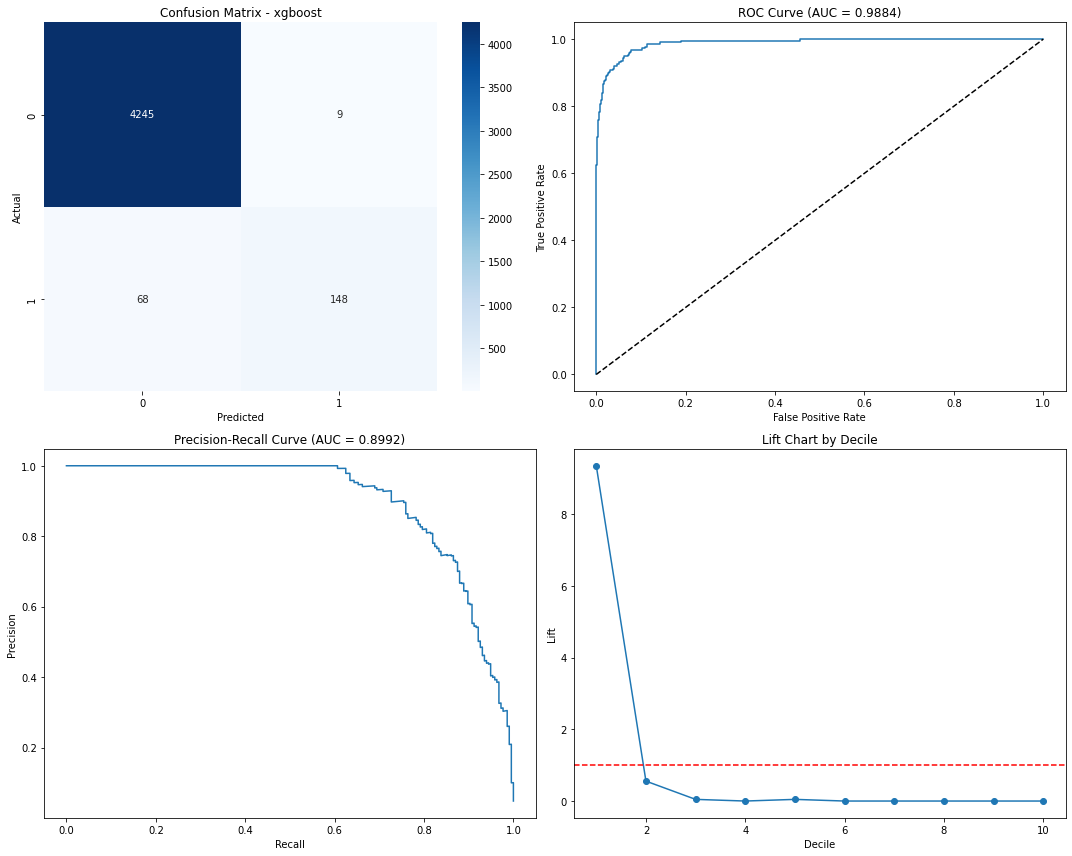

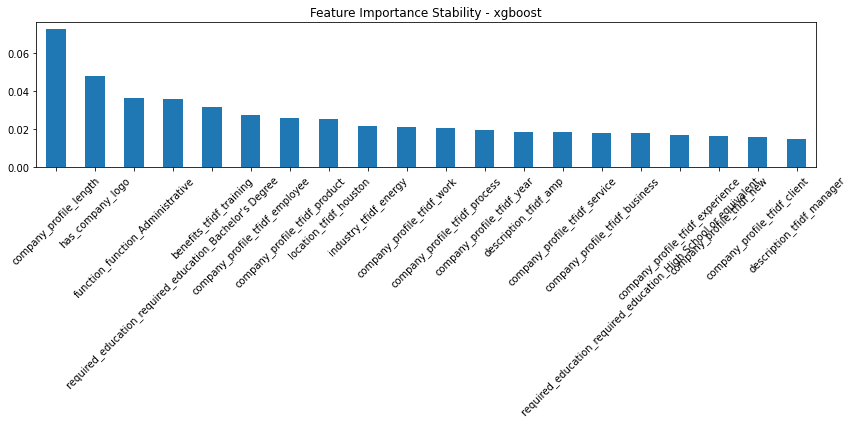

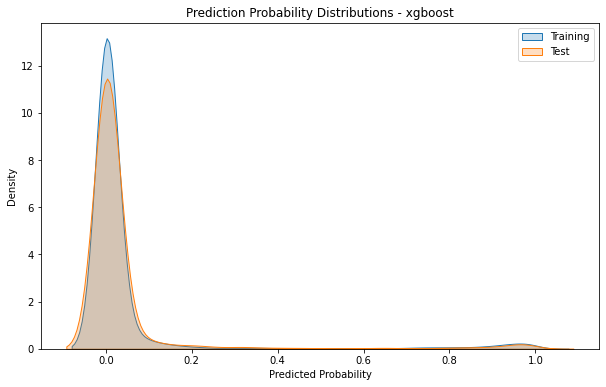


Evaluating neural_net

neural_net Performance:
ROC AUC: 0.9649
Recall: 0.6481
Precision: 0.8046
Balanced Accuracy: 0.8201
PR AUC: 0.7837
Average Precision: 0.7844

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      4254
           1       0.80      0.65      0.72       216

    accuracy                           0.98      4470
   macro avg       0.89      0.82      0.85      4470
weighted avg       0.97      0.98      0.97      4470


Lift Scores by Decile:
Decile 1: 8.66
Decile 2: 0.65
Decile 3: 0.37
Decile 4: 0.14
Decile 5: 0.09
Decile 6: 0.00
Decile 7: 0.05
Decile 8: 0.00
Decile 9: 0.05
Decile 10: 0.00


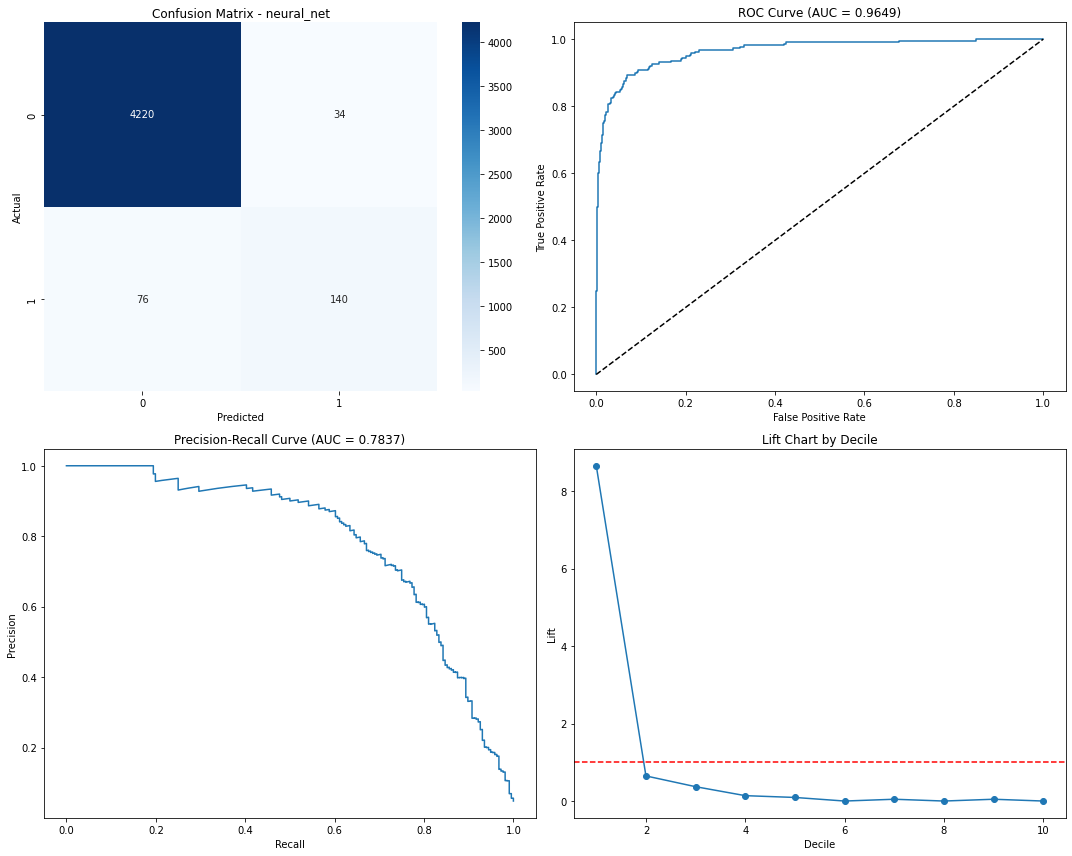

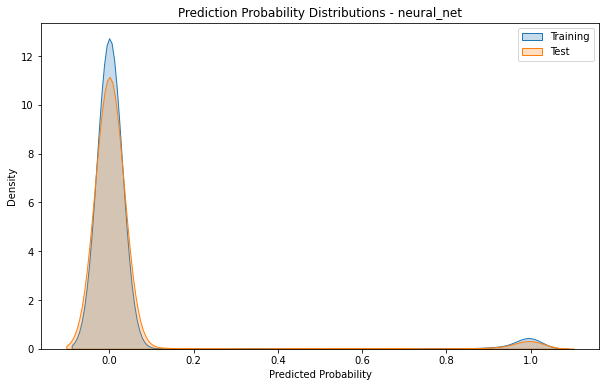


Saving models...
Models saved successfully!

Comparison of Model Performance:
            Model   ROC AUC    Recall  Precision  Balanced Accuracy    PR AUC  \
0         xgboost  0.985042  0.662037   0.928571           0.829726  0.880479   
1      neural_net  0.964895  0.648148   0.804598           0.820078  0.783727   
2  Stacking Model  0.988005  0.689815   0.955128           0.844085  0.894766   

   Average Precision  
0           0.880664  
1           0.784394  
2           0.894923  


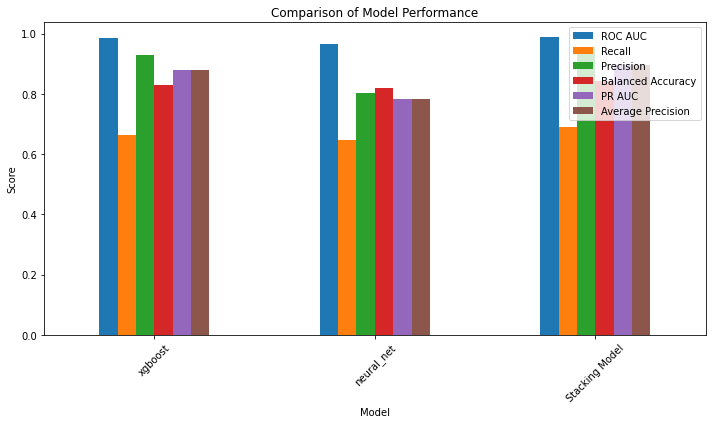


Analyzing xgboost for overfitting...

Fitting xgboost...


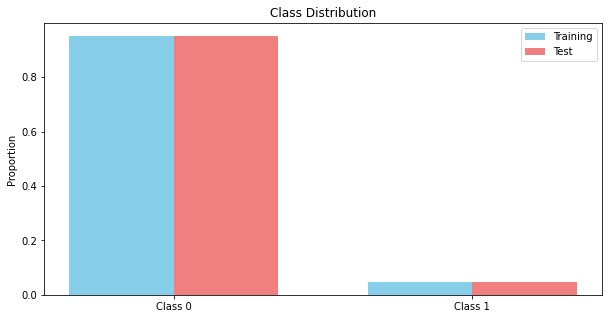

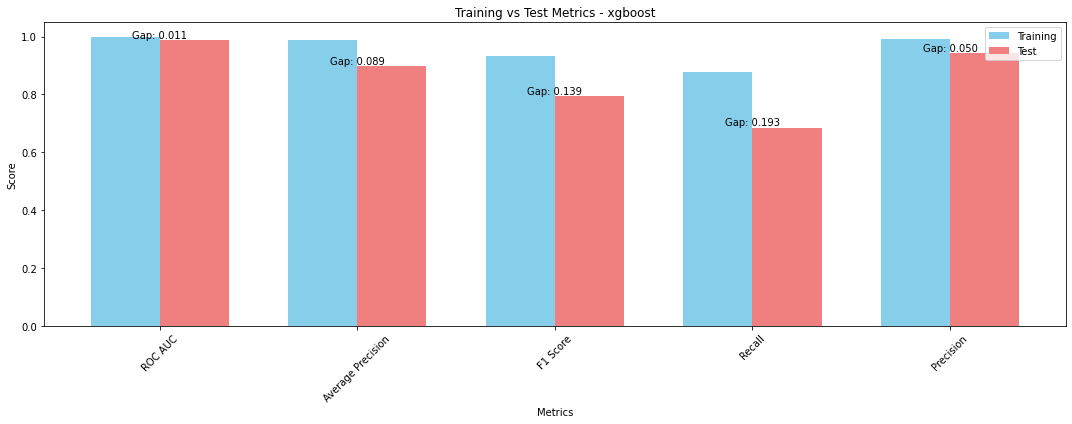

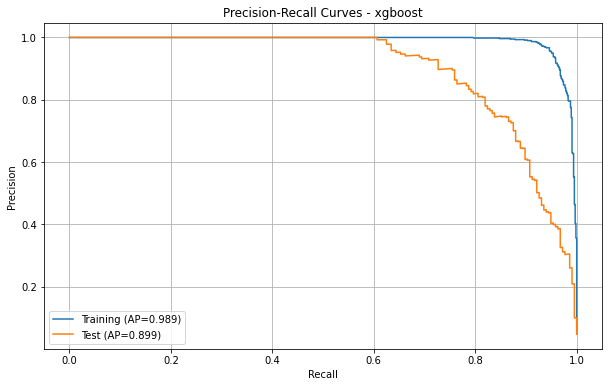


Overfitting Analysis for xgboost (Imbalanced Classification)
----------------------------------------------------------------------

Class Distribution:
Training Set:
Class 0: 0.952
Class 1: 0.048

Test Set:
Class 0: 0.952
Class 1: 0.048

Metrics Analysis:

ROC AUC:
Training Score: 0.9991
Test Score: 0.9884
Gap: 0.0107
Status: Good fit

Average Precision:
Training Score: 0.9886
Test Score: 0.8994
Gap: 0.0893
Status: Moderate overfitting

F1 Score:
Training Score: 0.9322
Test Score: 0.7936
Gap: 0.1387

Recall:
Training Score: 0.8785
Test Score: 0.6852
Gap: 0.1933

Precision:
Training Score: 0.9930
Test Score: 0.9427
Gap: 0.0504

Detailed Classification Report (Training):
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     12760
           1       0.99      0.88      0.93       650

    accuracy                           0.99     13410
   macro avg       0.99      0.94      0.96     13410
weighted avg       0.99      0.99      0.99     

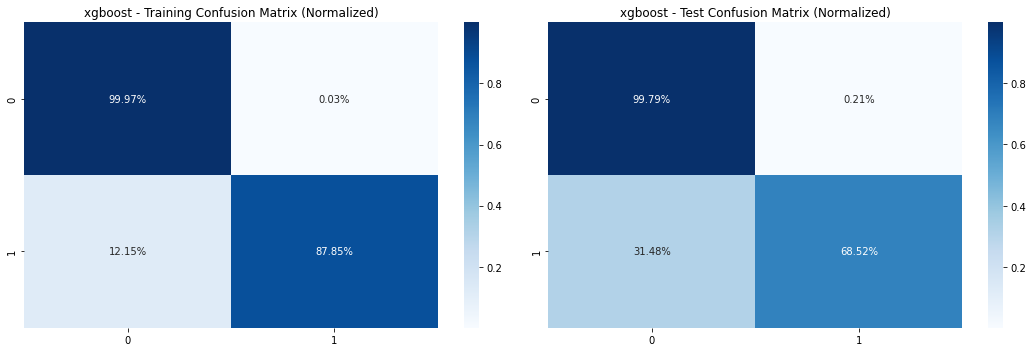


Analyzing neural_net for overfitting...

Fitting neural_net...


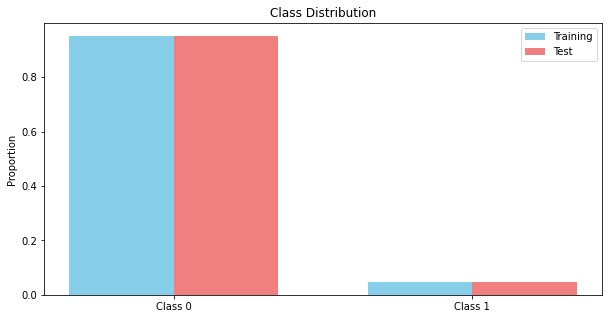

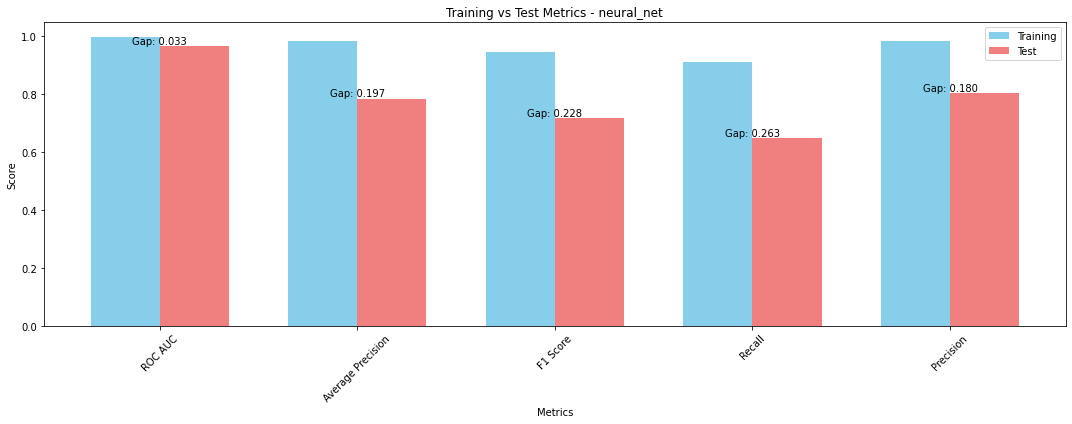

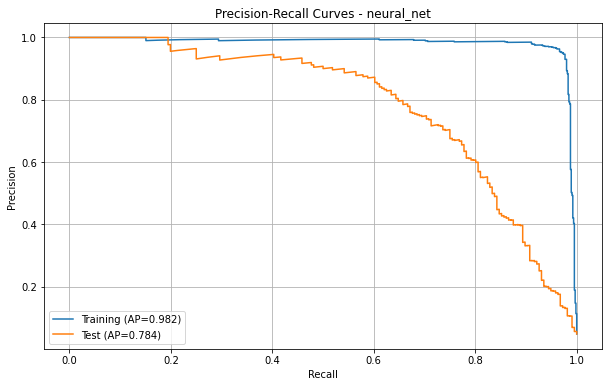


Overfitting Analysis for neural_net (Imbalanced Classification)
----------------------------------------------------------------------

Class Distribution:
Training Set:
Class 0: 0.952
Class 1: 0.048

Test Set:
Class 0: 0.952
Class 1: 0.048

Metrics Analysis:

ROC AUC:
Training Score: 0.9978
Test Score: 0.9649
Gap: 0.0329
Status: Good fit

Average Precision:
Training Score: 0.9818
Test Score: 0.7844
Gap: 0.1974
Status: High overfitting

F1 Score:
Training Score: 0.9464
Test Score: 0.7179
Gap: 0.2285

Recall:
Training Score: 0.9108
Test Score: 0.6481
Gap: 0.2626

Precision:
Training Score: 0.9850
Test Score: 0.8046
Gap: 0.1804

Detailed Classification Report (Training):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12760
           1       0.99      0.91      0.95       650

    accuracy                           1.00     13410
   macro avg       0.99      0.96      0.97     13410
weighted avg       0.99      1.00      0.99     1

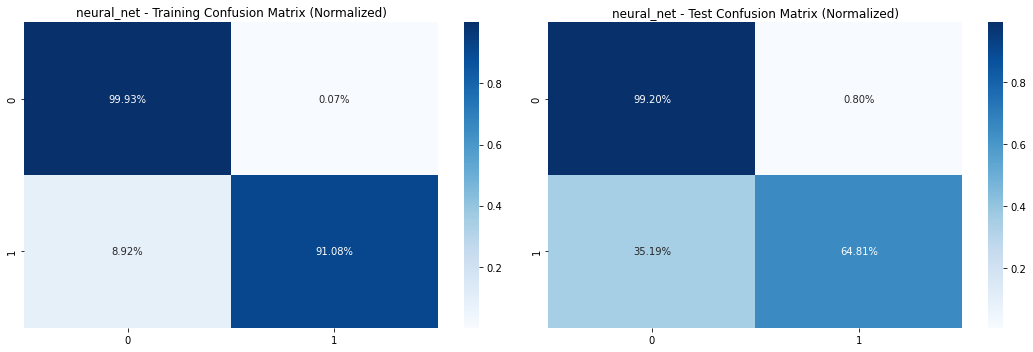


Analyzing Stacking Model for overfitting...

Fitting Stacking Model...


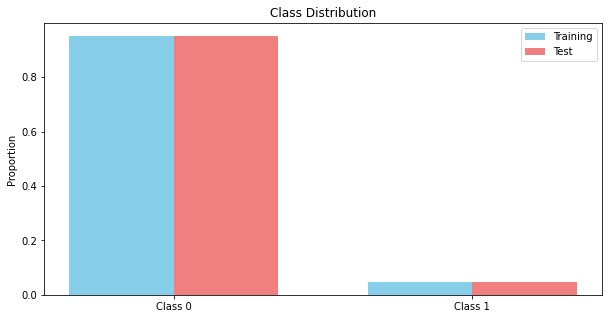

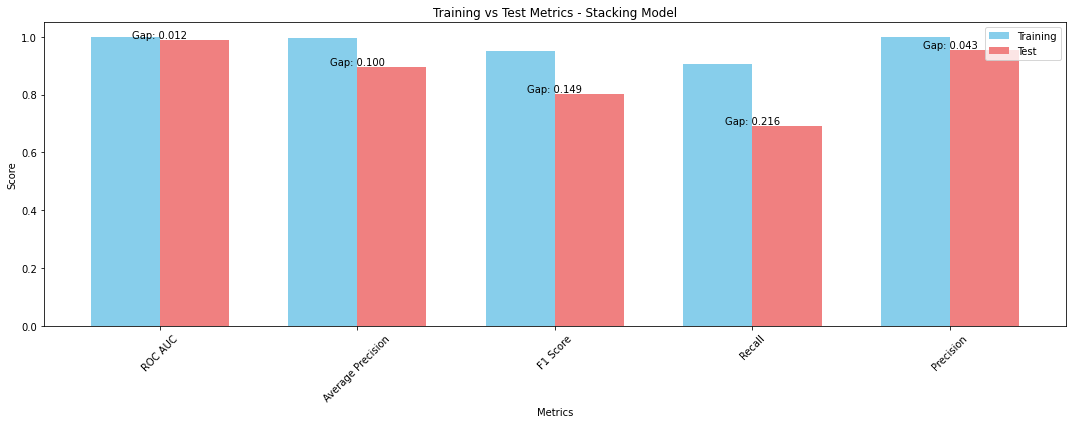

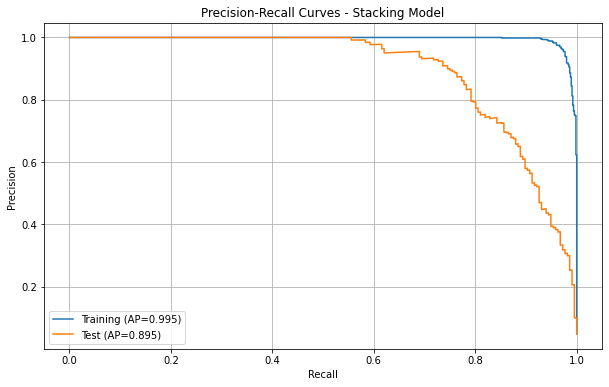


Overfitting Analysis for Stacking Model (Imbalanced Classification)
----------------------------------------------------------------------

Class Distribution:
Training Set:
Class 0: 0.952
Class 1: 0.048

Test Set:
Class 0: 0.952
Class 1: 0.048

Metrics Analysis:

ROC AUC:
Training Score: 0.9997
Test Score: 0.9880
Gap: 0.0117
Status: Good fit

Average Precision:
Training Score: 0.9953
Test Score: 0.8949
Gap: 0.1004
Status: High overfitting

F1 Score:
Training Score: 0.9500
Test Score: 0.8011
Gap: 0.1489

Recall:
Training Score: 0.9062
Test Score: 0.6898
Gap: 0.2163

Precision:
Training Score: 0.9983
Test Score: 0.9551
Gap: 0.0432

Detailed Classification Report (Training):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12760
           1       1.00      0.91      0.95       650

    accuracy                           1.00     13410
   macro avg       1.00      0.95      0.97     13410
weighted avg       1.00      1.00      1.00  

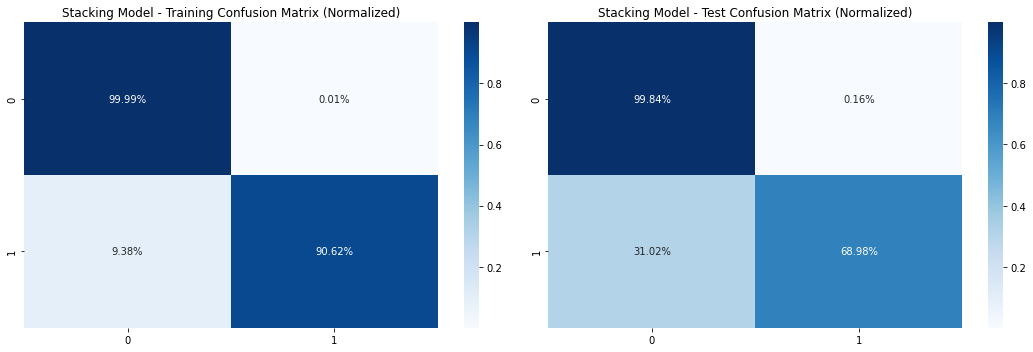

In [11]:
def save_models(optimized_models, stacking_model):
    """Save all trained models"""
    print("\nSaving models...")
    import os
    os.makedirs('models', exist_ok=True)
    
    joblib.dump(stacking_model, 'models/stacking_model.joblib')
    for name, (model, _) in optimized_models.items():
        joblib.dump(model, f'models/{name}_model.joblib')
    print("Models saved successfully!")


df = pd.read_pickle('data/engineered_features.pkl')
X_train, X_test, y_train, y_test = prepare_and_save_data(df, oversampling_ratio=6.0,test_size=0.25)

if __name__ == "__main__":
    print("Loading processed data...")
    try:
        X_train = pd.read_pickle('data/X_train.pkl')
        X_test = pd.read_pickle('data/X_test.pkl')
        y_train = pd.read_pickle('data/y_train.pkl')
        y_test = pd.read_pickle('data/y_test.pkl')
        print("Loaded existing data splits!")
    except FileNotFoundError:
        print("Creating new data splits...")
        df = pd.read_pickle('data/engineered_features.pkl')

        
        X_train, X_test, y_train, y_test = prepare_and_save_data(df, oversampling_ratio=6.0,test_size=0.25)

    # Optimize models
    # f1_weighted,  precision, roc_auc, balanced_accuracy, average_precision
    optimization_goal = 'f1_weighted'
    optimized_models = optimize_all_models(X_train, y_train, optimization_goal=optimization_goal,factor=3,cv=2)
    
    # Create and train stacking model
    stacking_model = create_stacking_model(optimized_models, X_train, y_train)
    
    # Evaluate stacking model
    print("Stacking model created and trained successfully.")
    print("Stacking model estimators:", stacking_model.estimators_)
    print("Final estimator:", stacking_model.final_estimator_)
    
    # Print best score for final estimator
    best_score = max(score for _, (_, score) in optimized_models.items())
    print(f"Best score ({optimization_goal}) for final estimator: {best_score:.4f}")
    
       
    # Evaluate models
    models = {name: model for name, (model, _) in optimized_models.items()}
    for model_name, model in models.items():
        print(f"\nEvaluating {model_name}")
        evaluate_model(model, X_test, y_test, model_name=model_name)
     

    # Save models
    save_models(optimized_models, stacking_model)
    
    # Evaluate and compare multiple models
    models = {name: model for name, (model, _) in optimized_models.items()}
    models['Stacking Model'] = stacking_model
    evaluate_multiple_models(models, X_test, y_test)
    
    # Check for imbalanced overfitting
    for model_name, model in models.items():
        print(f"\nAnalyzing {model_name} for overfitting...")
        check_imbalanced_overfitting(model, X_train, X_test, y_train, y_test, model_name)